# Transaction Fee Update Rules: Average Case Analysis

Start by choosing the simulation environment: the update rule and the distribution of valuations. One of the two, will be changing across the experiment according to the bifurcation parameter (learning rate or range of valuations). Let $T$ denote the target block-size, which we normalize to $T=1$, and let
$$y_t:=\frac{g_t-T}{T} = g_t-1,$$ where $g_t:=g(b_t)$ is the block-size of block at height $t$ given that the basefee is $b_t$. 
---
The **update rule** can be any of 

| Update Rule $\phantom{444444}$ | Description    | Comment  |
| :----------- | :---------- | :----|
| linear      | $b_{t+1} = b_t(1+dy_t)$ |  |
| exponential | $$b_{t+1} = b_t(1+d)^{y_t}\phantom{44444}$$|  |
| amm |$b_{t+1}=\frac{d}{T/2}e^{dz_t}$ | $$\text{where } z_t=\max{\left\{0, z_{t-1}+y_{t-1}\right\}} \text{ and } z_0=0.$$| 

---
The **distribution of valuations**, $\text{rv}(m,w)$, can be any of

| Distribution $\phantom{44}$ | Parameters |$(\mu, \sigma^2)\phantom{44444}$  | Support | Comment  |
| :----------- | :----- | :------- | :---------| :---- |
| uniform | $m$ | $w^2/12$ | $[m-w/2, m + w/2]$ |
| normal | $m$ |$ w^2/16$  | $(m-w,m+w)$ (essentially)$\phantom{5555}$ |
| gamma | $m+aw$ |$ w^2a$ | $$\hspace{-65pt}[m-aw,+\infty)$$ | $a=1 \to$ exponential| 

--- 

#### Import packages; initialize parameters and environment

The code in the next cell has the following functionalities
- imports required modules
- defines the dictionary "parameters" with all model parameters
- defines the dictionary "environment" with the update rule and the distribution of valuations
- stores the update rule in ur and the distribution of valuations in rv. Note that one of the two will keep changing later on depending on which (bifurcation) parameter we want to study.

In [1]:
%matplotlib inline
%pylab inline
import scipy
import scipy.stats
import numpy as np
from scipy.optimize import brentq
from collections.abc import Iterable 

def initialize_experiment(rule, distribution, d, w):

    parameters  = { # maximum blocksize T, is set to 1)
    "m": 210, 
    "w": w, 
    "d": d, 
    "demand": 4, 
    "premium": 1
    }
    environment = {
    "rule": rule, 
    "distribution": distribution
    }
    return parameters, environment

def dist_valuations(m, w, distribution):
    if distribution == "uniform":
        rv = scipy.stats.uniform(loc = m-w/2, scale = w)
        # uniform distribution with mean m and variance w^2/12 on [m-w/2, m + w/2]
        
    elif distribution == "normal":
        rv = scipy.stats.norm(loc = m, scale = w/4)
        # normal distribution with mean = m and variance w^2/16 (essentially) on [m-w, m+w] (w are 4 stds)
        
    elif distribution == "gamma":
        a  = 1 # if a = 1 this is the exponential
        rv = scipy.stats.gamma(a, loc = m-a*w, scale = w)
        # gamma distribution starting at m-a*w with mean m and variance a*w^2 on [m-a*w, infty).         

    return rv


def update_rule(rule):
    if rule == "linear":
        def fbf(basefee, blocksize, d, exgas):
            y  = blocksize - 1
            ex = max(0, exgas + y)
            bf = basefee*(1 + d*y)
            return bf, ex
        
    elif rule == "exponential":
        def fbf(basefee, blocksize, d, exgas):
            y  = blocksize - 1   
            ex = max(0, exgas + y)
            bf = basefee*(1 + d)**y 
            return bf, ex
    
    elif rule == "amm":
        def fbf(basefee, blocksize, d, exgas):
            y  = blocksize - 1
            ex = max(0, exgas + y)
            q  = 0.1
            bf = q*np.exp(q*ex)
            return bf, ex
    
    elif rule == "proportional":
        def fbf(basefee, blocksize, d, exgas):
            param = 0 
            y  = blocksize - 1
            ex = max(0, exgas + y)
            bf = basefee*(1 + d*y) + param * y
            return bf, ex

    return fbf

Populating the interactive namespace from numpy and matplotlib


The next function provides $b^*$ and the boundaries for the linear rule

In [2]:
def calc_bstar(parameters, rv):
    L = parameters["m"]
    U = parameters["m"] + 4*parameters["w"] 
    bstar = rv.isf(1/parameters["demand"]) - parameters["premium"] 
    bmin  = (1 - parameters["d"])*bstar;
    bmax  = (1 + parameters["d"])*bstar;

    return bstar, bmin, bmax

#### Define main and auxiliary functions for dynamics and plots
In the next cell, we define the main subroutines to run the dynamics

In [3]:
def main_step(bf, parameters, rv, ur, ex):
    blz     = np.min((2, parameters["demand"]*rv.sf(bf + parameters["premium"])))
    bf, ex  = ur(bf, blz, parameters["d"], ex)
    return bf, blz, ex

def IterateList(x, Niter, Nskip, parameters, rv, ur, ex):
    for i in range(Nskip):
        x, blz, ex = main_step(x, parameters, rv, ur, ex)
    
    xs = [x]
    bs = [blz]
    es = [ex]
    
    for i in range(Niter-1):
        x, blz, ex = main_step(x, parameters, rv, ur, ex)
        xs.append(x)
        bs.append(blz)
        es.append(ex)
    
    return xs, bs, es

def run_eip(hyperparameters, rv):
    [dMin, dMax, deltad, x0, e0, Nskip, Niter] = hyperparameters
    dArray = np.arange(dMin, dMax, deltad)
    ds     = []
    dsm    = []
    trajx  = []
    trajxm = []
    trajb  = []
    trajbm = []    
    traje  = []
    trajem = []
    bstars = []
    bmins  = []
    bmaxs  = []
    for d in dArray:
        dsm.extend([d]*1)
        ds.extend([d]*Niter)
        parameters["d"] = d 
        ur = update_rule(environment["rule"])
        xs, bs, es = IterateList(x0, Niter, Nskip, parameters, rv, ur, e0)
        trajx.extend(xs)
        trajb.extend(bs)
        traje.extend(es)
        trajxm.append(np.mean(xs))
        trajbm.append(np.mean(bs))
        trajem.append(np.mean(es))        
        [bstar,bmin,bmax] = calc_bstar(parameters,rv)
        bstars.append(bstar)
        bmins.append(bmin)
        bmaxs.append(bmax)
    return ds, trajx, trajb, traje, dsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs

In [12]:
def BifurcationDiagram_average(output):
    [ws, trajx, trajb, traje, wsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs] = output
    
    trajb  = [x / 2 for x in trajb]
    trajbm = [x / 2 for x in trajbm]
    
    fig, ax = plt.subplots(2, 2, sharex = True, figsize=(24,12), tight_layout=False)   
    fig.suptitle('Bifurcation diagrams: individual (top) and averages (bottom)')
    plt.rcParams['font.size'] = '20'
    plt.tight_layout(w_pad = 4, h_pad = 2, pad = 1)

    plt.subplot(221)
    scatter(ws, trajx, marker ='.', s = 2)
    plot(wsm,bstars,'r')
    plot(wsm,bmins,'--r')
    plot(wsm,bmaxs,'--r')
    lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], loc="upper left")
    lgnd.legendHandles[3]._sizes = [500]   
    ylabel('Base fee')
    xlim([0, 0.5])
    ylim([100, 320])
    
    plt.subplot(223)
    scatter(wsm, trajxm, marker ='.', s = 20)
    plot(wsm,bstars,'r')
    plot(wsm,bmins,'--r')
    plot(wsm,bmaxs,'--r')
    lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','base fee (averages)'], loc="upper left")
    lgnd.legendHandles[3]._sizes = [500]   
    ylabel('Base fee')
    xlabel('Adjustment quotient $d$')
    xlim([0, 0.5])
    ylim([100, 320])

    plt.subplot(222)
    scatter(ws, trajb, marker ='.', s = 2)
    ylabel('Block sizes')
    xlim([0, 0.5])
    lgnd = legend(['block size $g_t$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], loc="upper left")
    lgnd.legendHandles[0]._sizes = [500]    
    
    plt.subplot(224)
    scatter(wsm, trajbm, marker ='.', s = 20)
    ylabel('Block sizes')
    xlabel('Adjustment quotient $d$')
    xlim([0, 0.5])
    ylim([0.45, 0.65])
    lgnd = legend(['block size (averages)','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], loc="upper left")
    lgnd.legendHandles[0]._sizes = [500] 

In the next cell, we define the code to generate the plot

#### Run the dynamic
The next routine runs the dynamic and returns the trajectories of blocksizes and basefees. First, in the next, set the parameters of the experiment
- hyperparameters = [`dMin, dMax, Deltad, x0, e0, Nskip, Niter`]
- output = [`ds, trajx, trajb, dsm, trajxm, trajbm, bstars, bmins, bmaxs`]

where `ds`, `trajx` (basefees), `trajb` (blocksizes) refer to individual trajectories and `dsm`, `trajxm`, `trajbm` to averages. The ideal values (that achieve 0.5 blocksize) are stored in `bstars` and `bmins, bmaxs` refer to the bounds for the linear-EIP1559.

In [16]:
parameters, environment = initialize_experiment(rule = "exponential", distribution = "gamma", d = 0.125, w = 5) 
rv = dist_valuations(parameters["m"], parameters["w"], environment["distribution"])

In [17]:
hyperparameters = [0.001, 0.7, 0.001, 100, 0, 500, 100] # dMin, dMax, Deltad, x0, e0, Nskip, Niter
output = run_eip(hyperparameters, rv)

#### Plots
Using the outputs from the previous routine "run_eip()", we plot the bifurcation diagrams in the next cell

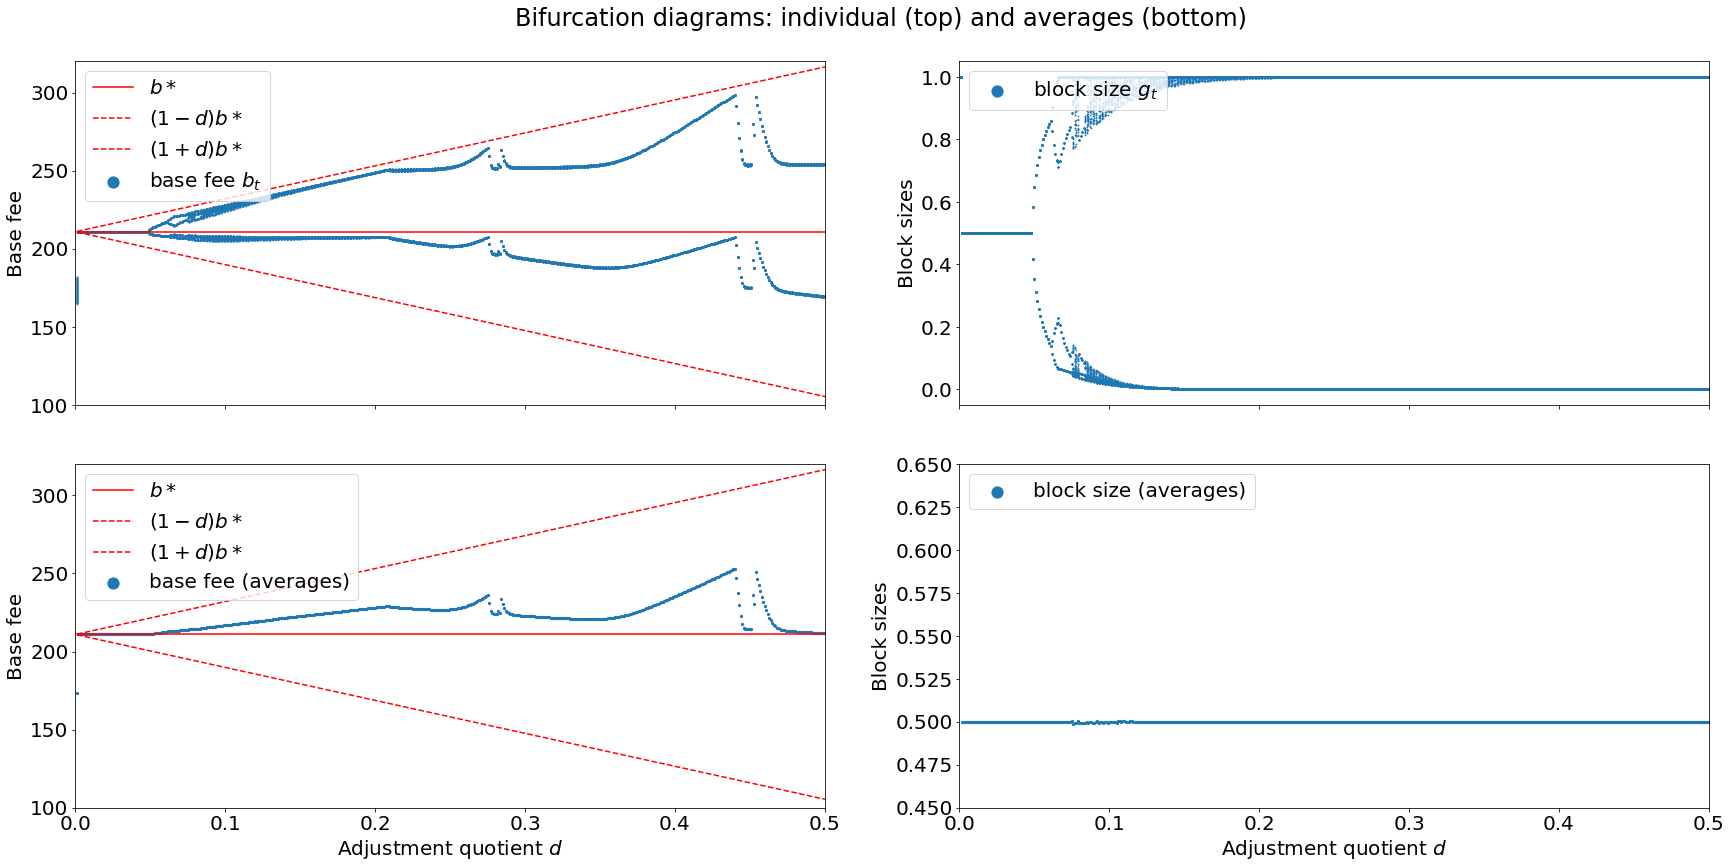

In [18]:
#uncomment to generate average trajectory plots
BifurcationDiagram_average(output)
savefig('fig_all_exp.jpg',bbox_inches='tight', dpi=50)